In [38]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)


In [8]:
# url from the Covid-19 data is extracted
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

In [9]:
def get_data(url):
    
    """
    Reads CSV data COVID-19 data of different counties from the url  
    
    INPUT: URL of the CSV
    OUTPUT: Pandas dataframe

    """
    
    url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
    covid_data = pd.read_csv(url,sep=",")
    print(f"The number of unique countries in the data are {len(covid_data['location'].unique())}")
    
    return covid_data
    

In [10]:
def clean_data(df):
    """
    Takes in the dataframe and
    - removes unnecessary columns
    - fills the NaN values with zeroes [Assumption: NaN means there were no cases that day instead of filling it with mean values] 
    - correcting the datetime format
    
    INPUT: Pandas dataframe
    OUTPUT: Cleaned dataframe

    """
    cases = df[['date','location','new_cases_smoothed','total_cases', 'total_deaths', 'new_deaths_smoothed']]
    cases = cases.fillna(0)
    
    # converting date object into datetime
    cases["date"]= pd.to_datetime(cases["date"])
    
    # reseting the index
    cases = cases.reset_index(drop = True)
    
    loc = "E:/uni/Data_Science_E/Data_Science_Enterprise/data/final_cases.csv"
    # saving the dataset
    cases.to_csv(loc,index=False)
    
    return cases
    

### Dashboard preparation

In [11]:
# url from the Covid-19 data is extracted
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"

covid_data = get_data(url)
cases = clean_data(covid_data)


fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([

    dcc.Markdown('''
    #  Applied Data Science on COVID-19 data

    Goal of the project is to teach data science by applying a cross industry standard process,
    it covers the full walkthrough of: automated data gathering, data transformations,
    filtering and machine learning to approximating the doubling time, and
    (static) deployment of responsive dashboard.

    '''),

    dcc.Markdown('''
    ## Multi-Select Country for visualization
    '''),


    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': each,'value':each} for each in cases['location'].unique()],
        value=['Germany','Italy'], # which are pre-selected
        multi=True
    ),

    dcc.Markdown('''
        ## Select other graphs
        '''),


    dcc.Dropdown(
    id='daily_stats',
    options=[
        {'label': 'Daily New Cases', 'value': 'new_cases_smoothed'},
        {'label': 'Daily New Deaths', 'value': 'new_deaths_smoothed'},
        {'label': 'Total Cases', 'value': 'total_cases'},
        {'label': 'Total Deaths', 'value': 'total_deaths'},
    ],
    value='new_cases_smoothed',
    multi=False
    ), 

    dcc.Graph(figure=fig, id='main_window_slope')
])


@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('country_drop_down', 'value'),
    Input('daily_stats', 'value')])

def update_figure(country_list,show_stats):

    traces = []
    for each in country_list:

        df_plot=cases[cases['location']==each]


        traces.append(dict(x=df_plot.date,
                                y=df_plot[show_stats],
                                mode='markers+lines',
                                opacity=0.9,
                                name=each
                        )
                )

    return {
            'data': traces,
            'layout': dict (
                width=1280,
                height=720,

                xaxis={'title':'Timeline',
                        'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="#7f7f7f"),
                      }
        )
    }

if __name__ == '__main__':

    app.run_server(debug=True, use_reloader=False)

The number of unique countries in the data are 244
Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


## SIR Modelling

In [31]:
germany = cases[cases["location"] == "Germany"].total_cases.astype("int64").reset_index(drop=True)
germany[35]

150

In [32]:
# set some basic parameters
# beta/gamma is denoted as  'basic reproduction number'

N0=1000000 #max susceptible population
beta=0.4   # infection spread dynamics
gamma=0.1  # recovery rate



# condition I0+S0+R0=N0
I0=cases[cases["location"] == "Germany"].total_cases.astype("int64").reset_index(drop=True)[35]
S0=N0-I0
R0=0

In [33]:
def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])


# Simulative approach to calculate SIR curves

In [34]:

SIR=np.array([S0,I0,R0])
propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recoverd':R0})



for each_t in np.arange(100):
   
    new_delta_vec=SIR_model(SIR,beta,gamma)
   
    SIR=SIR+new_delta_vec
    
    propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\3547986727.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



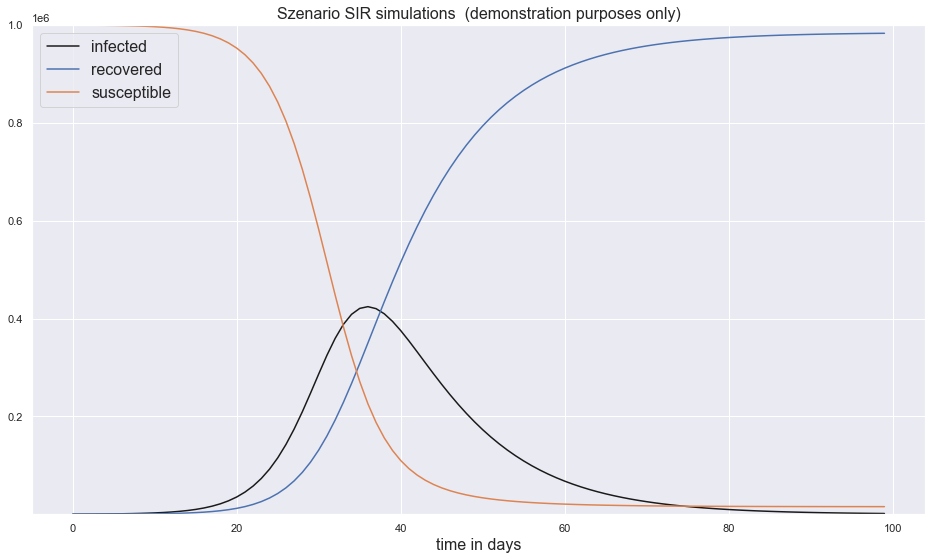

In [39]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',color='k')
ax1.plot(propagation_rates.index,propagation_rates.recovered,label='recovered')
ax1.plot(propagation_rates.index,propagation_rates.susceptible,label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

## Fitting the parameters of SIR modelling

In [40]:
ydata = np.array(germany[35:])
t=np.arange(len(ydata))

In [41]:
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0
beta

0.4

In [42]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [43]:


def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [44]:
# example curve of our differential equationa
popt=[0.4,0.1]
fit_odeint(t, *popt)

array([ 1.50000000e+02,  2.02463982e+02,  2.73268842e+02,  3.68819041e+02,
        4.97749399e+02,  6.71696875e+02,  9.06335369e+02,  1.22275981e+03,
        1.64933137e+03,  2.22412645e+03,  2.99816685e+03,  4.03964398e+03,
        5.43937699e+03,  7.31774561e+03,  9.83327943e+03,  1.31929070e+04,
        1.76634716e+04,  2.35833585e+04,  3.13717574e+04,  4.15310170e+04,
        5.46347118e+04,  7.12909430e+04,  9.20686199e+04,  1.17377266e+05,
        1.47302815e+05,  1.81425938e+05,  2.18681062e+05,  2.57335198e+05,
        2.95149063e+05,  3.29716023e+05,  3.58885018e+05,  3.81122439e+05,
        3.95696349e+05,  4.02654106e+05,  4.02648797e+05,  3.96705067e+05,
        3.86000511e+05,  3.71702658e+05,  3.54869154e+05,  3.36400476e+05,
        3.17028686e+05,  2.97327259e+05,  2.77731012e+05,  2.58559183e+05,
        2.40037812e+05,  2.22319621e+05,  2.05500760e+05,  1.89634472e+05,
        1.74741972e+05,  1.60820989e+05,  1.47852381e+05,  1.35805217e+05,
        1.24640639e+05,  

In [45]:
# the resulting curve has to be fitted
# free parameters are here beta and gamma

In [46]:
popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
perr = np.sqrt(np.diag(pcov))
    
print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])



D:\miniconda\lib\site-packages\scipy\integrate\_odepack_py.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\649699423.py:16: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\649699423.py:17: RuntimeWarning:

overflow encountered in double_scalars

C:\Users\yaaka\AppData\Local\Temp\ipykernel_1152\649699423.py:17: RuntimeWarning:

invalid value encountered in double_scalars



standard deviation errors :  [5.86138227e-04 5.97164071e-05]  start infect: 150
Optimal parameters: beta = 0.023612182779735605  and gamma =  -0.006069096840235439


In [47]:
# get the final fitted curve
fitted=fit_odeint(t, *popt)

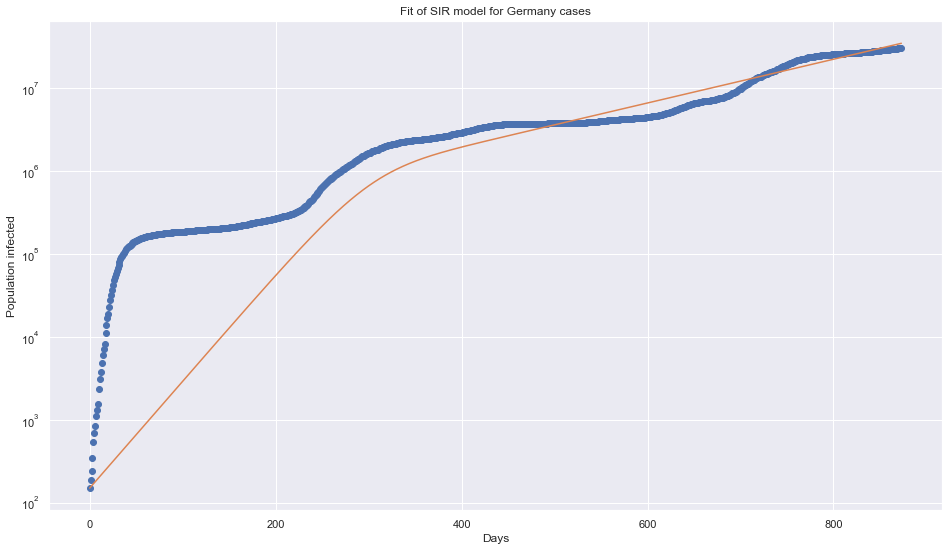

Optimal parameters: beta = 0.023612182779735605  and gamma =  -0.006069096840235439
Basic Reproduction Number R0  -3.8905595678087113
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [48]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")